In [1]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split
from torchvision.datasets import FashionMNIST
from torchvision import transforms

from data_utils import dataset_split

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


## DATALOADER

In [3]:
# Preprocessing
data_transform = transforms.Compose(
    {
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5]) # mean, #std
    }
)

fashion_mnist_data = FashionMNIST(os.getcwd() + '\\data',download=True,train=True, transform = data_transform)

In [4]:
data_set = dataset_split(fashion_mnist_data, split = [0.9, 0.1])
train_data = data_set['train']
val_data = data_set['val']

train_batch_size =100
val_batch_size = 10

train_dataloader = torch.utils.data.DataLoader(
    train_data, batch_size = train_batch_size, shuffle = True, num_workers = 1
)

val_dataloader = torch.utils.data.DataLoader(
    val_data, batch_size=val_batch_size, shuffle=True, num_workers=1
)

In [5]:
for sample_batch in train_dataloader:
    #print(sample_batch)
    print(sample_batch[0].shape,sample_batch[1].shape)
    break

torch.Size([100, 1, 28, 28]) torch.Size([100])


## MLP (Multi-layer Perceptron) Define

In [6]:
#define model

class MLP(nn.Module):
    def __init__(self, in_dim: int, h1_dim: int, h2_dim: int, out_dim: int):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, h1_dim)
        self.linear2 = nn.Linear(h1_dim, h2_dim)
        self.linear3 = nn.Linear(h2_dim, out_dim)
        self.relu = F.relu

    def forward(self, input):
        x = torch.flatten(input, start_dim=1)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        out = self.linear3(x)
        #out = F.softmax(out)
        return out

## Model, Loss func, Optimizer and Logger Define

In [7]:
# define model
model = MLP(28*28,128,64,10).to(device)

# define Loss
loss_function = nn.CrossEntropyLoss()

# define optimizer
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)
max_epoch = 15

# define tensorboard logger
writer = SummaryWriter()
log_interval = 100

In [8]:
train_step = 0
for epoch in range(1, max_epoch +1):
    # Valid step
    with torch.no_grad():
        val_loss = 0.0
        val_corrects = 0

        for val_batch_idx, (val_images, val_labels) in enumerate(
            tqdm(val_dataloader, position = 0, leave=True,desc='validation')
        ):
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            #Forward
            val_outputs = model(val_images)
            _, val_preds = torch.max(val_outputs, 1)

            # loss & acc
            val_loss += loss_function(val_outputs, val_labels) / val_outputs.shape[0]
            val_corrects += torch.sum(val_preds ==  val_labels.data) / val_outputs.shape[0]

    # Valid step logging
    val_epoch_loss = val_loss / len(val_dataloader)
    val_epoch_acc = val_corrects / len(val_dataloader)


    #print(f"{epoch} epoch, {train_step} step: val_loss: {val_epoch_loss}, val_acc: {val_epoch_acc}")

    writer.add_scalar("Loss/val", val_epoch_loss, train_step)
    writer.add_scalar("Acc/val", val_epoch_acc, train_step)
    writer.add_images("Images/val", val_images, train_step)

    # Train step
    current_loss = 0
    current_corrects = 0

    for batch_idx, (images, labels) in enumerate(
        tqdm(train_dataloader,position=0,leave=True,desc='training')
    ):
        images = images.to(device)
        labels = labels.to(device)

        current_loss=0.0
        current_corrects = 0

        # Forward
        # get predictions
        outputs = model(images)
        _, preds =torch.max(outputs, 1)

        # get loss
        loss = loss_function(outputs, labels) # input , target

        # Backpropagation
        # optimizer initialization
        optimizer.zero_grad()

        #Perform backward pass
        loss.backward()

        # Perform Optimization
        optimizer.step()

        current_loss += loss.item()
        current_corrects += torch.sum(preds == labels.data)

        if train_step % log_interval == 0:
            train_loss = current_loss / log_interval
            train_acc = current_corrects / log_interval

            # print(f"{train_step}: train_loss: {train_loss}, train_acc: {train_acc}")

            writer.add_scalar("Loss/train", train_loss, train_step)
            writer.add_scalar("Acc/train", train_acc, train_step)
            writer.add_images("Images/train", images, train_step)
            writer.add_graph(model,images)
            current_loss = 0
            current_corrects = 0

        train_step +=1
    print(f"epoch: {epoch}, train_loss: {train_loss}, train_acc: {train_acc}")

writer.close()

training: 100%|██████████| 540/540 [00:08<00:00, 66.19it/s]


epoch: 1, train_loss: 0.0032493931055068968, train_acc: 0.8999999761581421


training: 100%|██████████| 540/540 [00:08<00:00, 65.46it/s]


epoch: 2, train_loss: 0.0038851025700569154, train_acc: 0.8799999952316284


training: 100%|██████████| 540/540 [00:08<00:00, 66.41it/s]


epoch: 3, train_loss: 0.0042956116795539855, train_acc: 0.8399999737739563


training: 100%|██████████| 540/540 [00:08<00:00, 66.78it/s]


epoch: 4, train_loss: 0.002740297019481659, train_acc: 0.9199999570846558


training: 100%|██████████| 540/540 [00:08<00:00, 66.99it/s]


epoch: 5, train_loss: 0.0034682437777519225, train_acc: 0.8899999856948853


training: 100%|██████████| 540/540 [00:08<00:00, 67.11it/s]


epoch: 6, train_loss: 0.002809319496154785, train_acc: 0.8999999761581421


training: 100%|██████████| 540/540 [00:08<00:00, 67.14it/s]


epoch: 7, train_loss: 0.0029733923077583315, train_acc: 0.8799999952316284


training: 100%|██████████| 540/540 [00:07<00:00, 67.62it/s]


epoch: 8, train_loss: 0.0016749103367328644, train_acc: 0.949999988079071


training: 100%|██████████| 540/540 [00:08<00:00, 67.45it/s]


epoch: 9, train_loss: 0.0023837178945541383, train_acc: 0.8899999856948853


training: 100%|██████████| 540/540 [00:08<00:00, 66.98it/s]


epoch: 10, train_loss: 0.0021728524565696717, train_acc: 0.9300000071525574


training: 100%|██████████| 540/540 [00:08<00:00, 66.53it/s]


epoch: 11, train_loss: 0.002725143730640411, train_acc: 0.8999999761581421


training: 100%|██████████| 540/540 [00:07<00:00, 69.95it/s]


epoch: 12, train_loss: 0.002383427768945694, train_acc: 0.9099999666213989


training: 100%|██████████| 540/540 [00:07<00:00, 69.57it/s]


epoch: 13, train_loss: 0.0022696684300899505, train_acc: 0.8999999761581421


training: 100%|██████████| 540/540 [00:07<00:00, 69.87it/s]


epoch: 14, train_loss: 0.002200005203485489, train_acc: 0.9399999976158142


training: 100%|██████████| 540/540 [00:07<00:00, 69.60it/s]

epoch: 15, train_loss: 0.0021763494610786437, train_acc: 0.9300000071525574


In [10]:
# %load_ext tensorboard
# %tensorboard --logdir runs

In [11]:
# save model
os.makedirs("./logs/models",exist_ok=True)
torch.save(model,"./logs/models/mlp.ckpt")

In [12]:
# load model
loaded_model = torch.load("./logs/models/mlp.ckpt").to(device)
loaded_model.eval()
print(loaded_model)

MLP(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)


In [13]:
def softmax(x,axis = 0):
    "numpy softmax"
    max = np.max(x, axis=axis, keepdims=True)
    e_x = np.exp(x - max)
    sum = np.sum(e_x, axis=axis, keepdims=True)
    f_x = e_x / sum
    return f_x

In [14]:
test_batch_size =100
test_dataset = FashionMNIST(os.getcwd() + '\\data', download=True,train=False,transform=transforms.ToTensor())
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=1)

test_labels_list = []
test_preds_list = []
test_outputs_list = []

for i, (test_images, test_labels) in enumerate(tqdm(test_dataloader, position=0, leave=True, desc = "testing")):

    test_images = test_images.to(device)
    test_labels = test_labels.to(device)

    #forward
    test_outputs = loaded_model(test_images)
    _, test_preds = torch.max(test_outputs, 1)

    final_outs = softmax(test_outputs.detach().cpu().numpy(), axis=1)
    test_outputs_list.extend(final_outs)
    test_preds_list.extend(test_preds.detach().cpu().numpy())
    test_labels_list.extend(test_labels.detach().cpu().numpy())

test_preds_list = np.array(test_preds_list)
test_labels_list = np.array(test_labels_list)

print(f"\nacc: {np.mean(test_preds_list == test_labels_list)*100}%")

testing: 100%|██████████| 100/100 [00:01<00:00, 56.08it/s]


acc: 63.44%


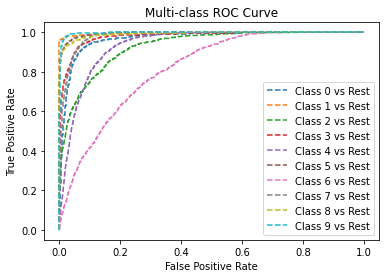

auc_score 0.9589122111111108


In [15]:
# ROC Curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr = {}
tpr = {}
thresh = {}
n_class = 10

for i in range(n_class):
    fpr[i],tpr[i],thresh[i] = roc_curve(test_labels_list, np.array(test_outputs_list)[:, i], pos_label = i)

# plot
for i in range(n_class):
    plt.plot(fpr[i], tpr[i], linestyle ="--", label = f"Class {i} vs Rest")
plt.title("Multi-class ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc = "best")
plt.show()

print("auc_score", roc_auc_score(test_labels_list,test_outputs_list,multi_class="ovo",average="macro"))